# (Try to) identify signals of gentrification from Airbnb data

In [72]:
import os
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import zscore, gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from datetime import datetime
import seaborn as sns
from shapely.geometry import Point
from geopandas import GeoDataFrame
from IPython.core.pylabtools import figsize
from fontTools.varLib.interpolatableHelpers import matching_for_vectors
import folium
import branca.colormap as cm
from sklearn.preprocessing import StandardScaler
import sys

sys.path.insert(0, '../')
from PlottingFunctions import *

cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

city='manchester'

### Get just Manchester LSOAs

In [73]:
lsoas =  gpd.read_file('../../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
manchester_lsoas=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]

In [74]:
manchester_lsoas = manchester_lsoas.to_crs(epsg=27700)

# Define Manchester city centre point (in WGS84, then project)
city_centre_wgs84 = Point(-2.2426, 53.4808)  # approx lat/lon of Manchester city centre
city_centre_point = gpd.GeoSeries([city_centre_wgs84], crs='EPSG:4326').to_crs(epsg=27700).iloc[0]

# Filter polygons within a buffer distance (e.g., 3 km radius)
buffer = city_centre_point.buffer(6000)  # 3000 meters
central_lsoas = manchester_lsoas[manchester_lsoas.intersects(buffer)]

## Get just Manchester LADs

In [75]:
LADs =  gpd.read_file('../../../data/SpatialData/LADs/LADs.shp')
manchester_LADs = LADs[LADs['LAD23NM'].str.contains(manc_lads_pattern, na=False, regex=True)]

In [76]:
### CHECK PLOTTING

# m = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB Positron")

# # Pass color as a default argument to the lambda function
# folium.GeoJson(manchester_lsoas,  style_function=lambda feature, color='red': {"fillColor": color, "color": "black", "weight": 1}).add_to(m)
# folium.GeoJson(manchester_LADs,  style_function=lambda feature, color='red': {"fillColor": color, "color": "black", "weight": 1}).add_to(m)
# display(m)

## Find the LAD which each LSOA is within

In [77]:
saved_polygon_geometry = manchester_lsoas['geometry']

# Convert manchester_lsoas to GeoDataFrame using LAT and LONG columns
geometry = [Point(xy) for xy in zip(manchester_lsoas['LONG'], manchester_lsoas['LAT'])]
manchester_lsoas = gpd.GeoDataFrame(manchester_lsoas, geometry=geometry)

# Ensure both GeoDataFrames use the same CRS (EPSG:27700 for BNG)
manchester_lsoas = manchester_lsoas.set_crs('EPSG:4326', allow_override=True)
manchester_lsoas = manchester_lsoas.to_crs(epsg=27700)

# Perform the spatial join using 'within' predicate (points within polygons)
manchester_lsoas = gpd.sjoin(manchester_lsoas, manchester_LADs[['LAD23NM', 'geometry']], how='left', predicate='within')

# Now, we have a new 'LAD23NM' column which we can rename as 'LAD'
manchester_lsoas['LAD'] = manchester_lsoas['LAD23NM']

# Optionally, drop the 'LAD23NM' column if it's not needed anymore
manchester_lsoas = manchester_lsoas.drop(columns=['LAD23NM'])

manchester_lsoas['geometry'] = saved_polygon_geometry

In [78]:
# manchester_lsoas is a geodataframe with column LSOA11NM. I want to join its spatial info to gentrication_cat_df which also has the column LSOA11NM, and then plot the column 

## Get gentrification scores

In [79]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
gentrification_cat_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_filtered_01.csv')

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
gentrification_cat_df['gentrification_prediction_code'] = gentrification_cat_df['gentrification_prediction'].map(mapping)
# Remove rows with an error
gentrification_cat_df = gentrification_cat_df[gentrification_cat_df['explanation'] != 'ERROR']

In [80]:
# del manchester_lsoas['index_right']
# del overall_gdf['index_right']
# gentrication_cat_df.columns
# del gentrication_cat_df['index_right']

In [81]:
# # Convert to geodtaframe
# gentrication_cat_df['geometry'] = gentrication_cat_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
# overall_gdf = gpd.GeoDataFrame(gentrication_cat_df, geometry='geometry', crs="EPSG:4326")
# overall_gdf = overall_gdf.to_crs(manchester_lsoas.crs)
# # Join to LSOA info
# overall_gdf = gpd.sjoin(overall_gdf, manchester_lsoas[['LSOA11NM', 'geometry']], how='left', predicate='within')

In [82]:
lsoa_scores_gentrification = gentrification_cat_df.groupby("LSOA11NM")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
central_lsoas = central_lsoas.merge(lsoa_scores_gentrification, on='LSOA11NM', how='left')
central_lsoas = central_lsoas[central_lsoas['gentrification_prediction_code'].notna()]

count = gentrification_cat_df.groupby("LSOA11NM")["gentrification_prediction_code"].count()
central_lsoas['count'] = count.values

In [83]:
# lsoa_scores_gentrification = gentrication_cat_df.groupby("LSOA11NM")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
# manchester_lsoas = manchester_lsoas.merge(lsoa_scores_gentrification, on='LSOA11NM', how='left')
# manchester_lsoas

In [84]:
lsoa_scores_gentrification = gentrification_cat_df.groupby("LSOA11NM")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0]).reset_index()

In [85]:
def dominant_and_percentage(x):
    mode_val = pd.Series.mode(x).iloc[0]
    pct = (x == mode_val).mean() * 100
    return pd.Series({'dominant_class': mode_val, 'dominant_pct': pct})

lsoa_scores_gentrification = (
    gentrification_cat_df
    .groupby("LSOA11NM")["gentrification_prediction_code"]
    .apply(dominant_and_percentage)
    .unstack()
    .reset_index())

In [112]:
cmap = plt.get_cmap('plasma', 5)
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

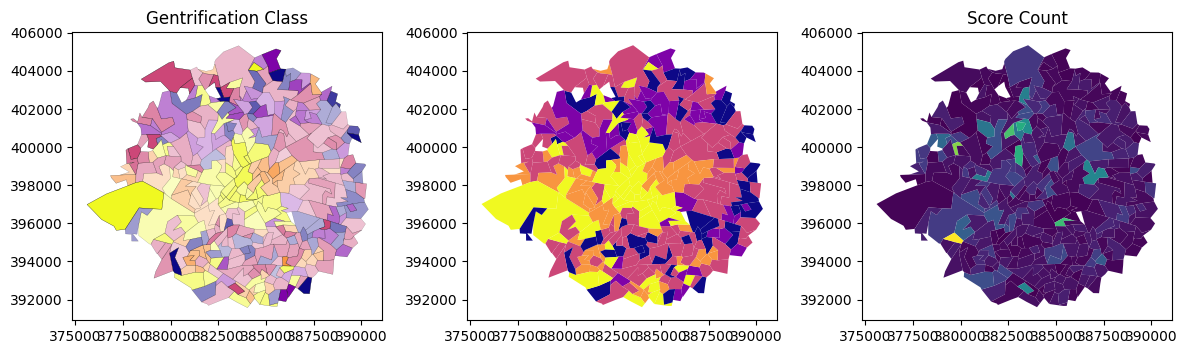

In [116]:
import geopandas as gpd
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
fig, axs = plt.subplots(ncols=3, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1, 1]})

# Left: plot polygons with alpha scaled by dominant_pct
cmap = plt.get_cmap("plasma", 5)  # categorical colormap

norm = Normalize(vmin=central_lsoas['gentrification_prediction_code'].min(),
                 vmax=central_lsoas['gentrification_prediction_code'].max())

for _, row in central_lsoas.iterrows():
    color = cmap(norm(row['gentrification_prediction_code']))  # now this works properly
    gpd.GeoSeries([row.geometry]).plot(ax=axs[0], color=color, alpha=row['alpha'], edgecolor='black', linewidth=0.2)

axs[0].set_title("Gentrification Class")

central_lsoas.plot(ax=axs[1], column="gentrification_prediction_code", cmap=cmap, legend=False)

# Right: plot 'count' column normally
central_lsoas.plot(ax=axs[2], column="count", cmap="viridis", legend=False)
axs[2].set_title("Score Count")

plt.tight_layout()
plt.show()


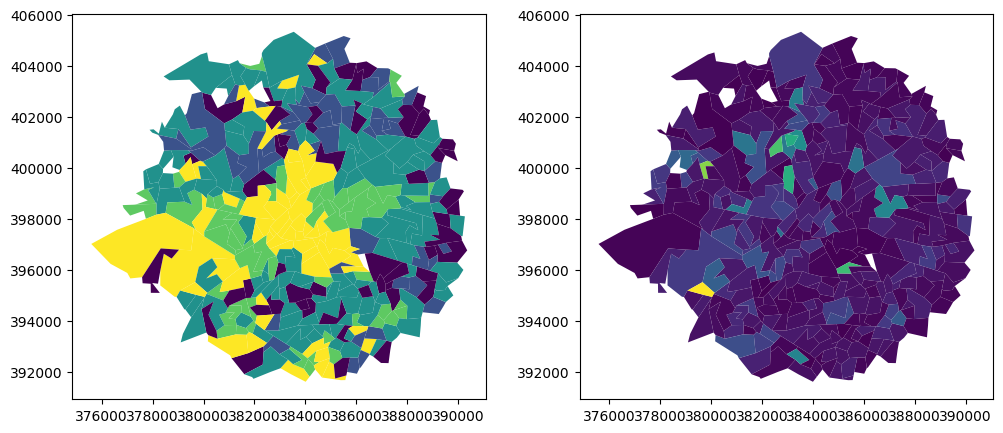

In [101]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})  # Ensure equal subplot sizes
central_lsoas.plot(ax = axs[0],column =  "gentrification_prediction_code")
central_lsoas.plot(ax = axs[1],column = "count");

## Plot

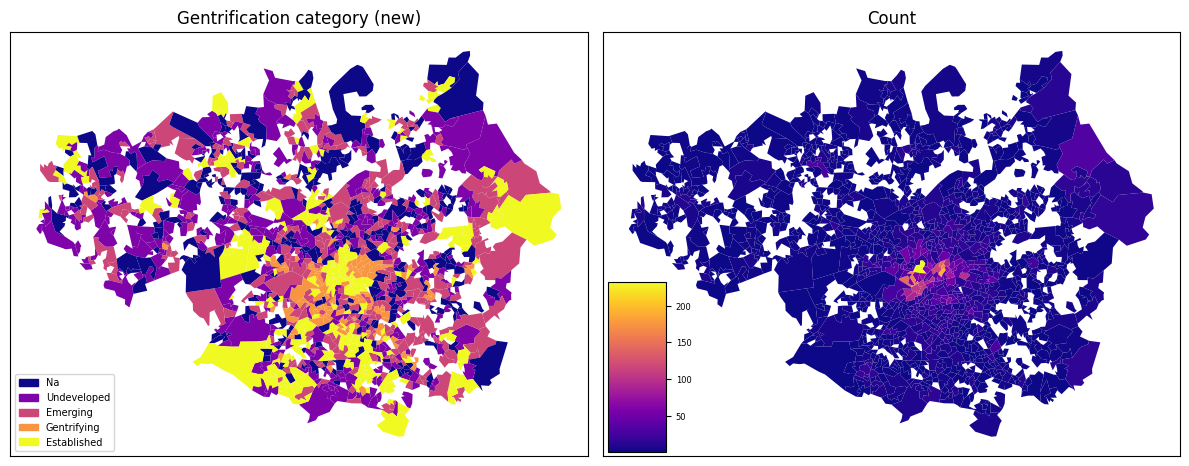

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})  # Ensure equal subplot sizes

cmap = plt.get_cmap('plasma')

# ---- PLOT 1: CATEGORICAL GENTRIFICATION ----
manchester_lsoas.plot(ax=axs[0], column='gentrification_prediction_code', cmap='plasma')

categories = sorted(manchester_lsoas['gentrification_prediction_code'].unique())
norm = colors.Normalize(vmin=min(categories), vmax=max(categories))

legend_patches = [
    mpatches.Patch(color=cmap(norm(cat)), label=f'{[k for k, v in mapping.items() if v == cat].pop()}')
    for cat in [0, 1, 2, 3, 4]]

axs[0].legend(handles=legend_patches, loc='lower left', fontsize=7)
axs[0].set_title("Gentrification category (new)")
axs[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# ---- PLOT 4: COUNT (WITH SMALLER INSET LEGEND) ----
manchester_lsoas.plot(ax=axs[1], column='Count', cmap="plasma", legend=False)  # Disable auto legend

axs[1].set_title("Count")
axs[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# **Manually add inset legend inside the plot**
axins = axs[1].inset_axes([0.01, 0.01, 0.1, 0.4])  # (x, y, width, height) in axis fraction
sm = plt.cm.ScalarMappable(cmap="plasma", norm=colors.Normalize(vmin=manchester_lsoas['Count'].min(), vmax=manchester_lsoas['Count'].max()))
cb = plt.colorbar(sm, cax=axins)
cb.ax.tick_params(labelsize=6)  # Smaller font for colorbar

# Adjust layout
plt.tight_layout()

plt.show()

In [6]:
# pattern = '|'.join(['Manchester', 'Stockport', 'Salford', 'Trafford', 'Tameside'])
# manchester_lsoas_filtered = manchester_lsoas[manchester_lsoas['LAD'].str.contains(pattern)] 
# # manchester_lsoas_filtered = manchester_lsoas

# # Ensure the GeoDataFrame has the correct CRS (Folium needs EPSG:4326)
# manchester_lsoas_filtered = manchester_lsoas_filtered.to_crs(epsg=4326)

# # Filter out rows with NaN values in 'gentrification_prediction_code'
# manchester_lsoas_filtered = manchester_lsoas_filtered[manchester_lsoas_filtered['gentrification_prediction_code'].notna()]

# # Define map center (approximate Manchester city center)
# map_center = [53.483959, -2.244644]
# m = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB Positron")

# # Use matplotlib's plasma colormap and create a linear scale
# cmap = plt.get_cmap('plasma')
# colormap = cm.LinearColormap(colors=[cmap(i) for i in range(cmap.N)], 
#                              vmin=manchester_lsoas['gentrification_prediction_code'].min(), 
#                              vmax=manchester_lsoas['gentrification_prediction_code'].max())

# # Add GeoJson layer with styling
# folium.GeoJson(
#     manchester_lsoas_filtered,
#     name="Gentrification",
#     style_function=lambda feature: {
#         "fillColor": colormap(feature['properties']['gentrification_prediction_code']),
#         "color": "black",
#         "weight": 0.5,
#         "fillOpacity": 0.7,
#     },
#     tooltip=folium.GeoJsonTooltip(fields=["LSOA11NMW", "gentrification_prediction_code"],
#                                   aliases=["LSOA:", "Gentrification Code:"])
# ).add_to(m)

# # Add the colormap legend
# colormap.caption = "Gentrification Category"
# m.add_child(colormap)

# # Display the map
# display(m)


## Rose plots

In [366]:
manc_lads_pattern = '|'.join(manc_lads)
indicators = pd.read_csv("../../data/SocioEconomicData/Eng_imputedV3.csv")
indicators_manchester = indicators[indicators['LA_NAME'].str.contains(manc_lads_pattern)].copy()
indicators_manchester = indicators_manchester.rename(columns={"LSOA": 'LSOA11CD'})
indicators_manchester = indicators_manchester.merge(manchester_lsoas[['LSOA11CD', 'gentrification_prediction_code']], on='LSOA11CD', how='left')
indicators_manchester.sort_values(by='gentrification_prediction_code', inplace=True)
del indicators_manchester['Churn_2020']

## Rescale values between 0 and 1

In [248]:
# numeric_cols = indicators_manchester.columns[:75]
# numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])

# # Rescale between 0 and 1
# indicators_manchester[numeric_cols] = (indicators_manchester[numeric_cols] - indicators_manchester[numeric_cols].min()) / \
#                                    (indicators_manchester[numeric_cols].max() - indicators_manchester[numeric_cols].min())

# # StandardScaler
# scaler = StandardScaler()
# scaled_values = scaler.fit_transform(indicators_manchester[numeric_cols])
# scaled_df = pd.DataFrame(scaled_values, columns=[col + "_Z" for col in numeric_cols])
# indicators_manchester = pd.concat([indicators_manchester, scaled_df], axis=1)

In [158]:
# fig, axs=plt.subplots(ncols=2)
# axs[0].hist(indicators_manchester['Churn_2008_Z'])
# axs[1].hist(indicators_manchester['Churn_2008'])

### Create Rose plot

In [314]:
# 1. Identify numeric columns
numeric_cols = indicators_manchester.columns
numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])

# 2. Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
scaled_minmax = minmax_scaler.fit_transform(indicators_manchester[numeric_cols])

# Convert scaled values back to DataFrame and concatenate with original non-numeric columns
scaled_minmax_df = pd.DataFrame(scaled_minmax, columns=numeric_cols)
indicators_manchester_minmax = pd.concat([indicators_manchester[['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']], scaled_minmax_df], axis=1)

# 3. Apply StandardScaler
standard_scaler = StandardScaler()
scaled_standard = standard_scaler.fit_transform(indicators_manchester[numeric_cols])

# Convert scaled values back to DataFrame and concatenate with original non-numeric columns
scaled_standard_df = pd.DataFrame(scaled_standard, columns=numeric_cols)
indicators_manchester_standard = pd.concat([indicators_manchester[['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']], scaled_standard_df], axis=1)

In [256]:
numeric_cols_Z = numeric_cols + "_Z"

In [387]:
def plot_mean_rose_with_group_labels(ax, indicators, color, all_vars):

    groups = {'Churn': [col for col in all_vars if 'Churn' in col], 'NINO': [col for col in all_vars if 'NINO' in col],
             'JSA': [col for col in all_vars if 'JSA' in col], 
              'HP': [col for col in all_vars if 'HP' in col],
              'PROF2POP': [col for col in all_vars if 'PROF2POP' in col]}
        
    # Example: Calculate means and std_devs (replace with your method)
    means = indicators[all_vars].mean().values.tolist()
    std_devs = indicators[all_vars].std().values.tolist()
    
    # Close loop for radar chart
    means += means[:1]
    std_devs += std_devs[:1]
    
    # Angles
    num_vars = len(all_vars)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Plotting means + gradient fills (your existing method)
    std_upper = np.array(means) + np.array(std_devs)
    std_lower = np.array(means) - np.array(std_devs)

    # Plot mean line
    ax.plot(angles, means, color='black', linewidth=2, label='Mean')

    # Simulate gradient by plotting multiple thin bands
    n_steps = 10  # Number of gradient layers
    for i in range(n_steps):
        alpha = 0.3 * (1 - i / n_steps)  # Fading alpha for gradient
        lower = std_lower + (means - std_lower) * (i / n_steps)
        upper = std_upper - (std_upper - means) * (i / n_steps)

        # Fill between lower and upper bands
        ax.fill_between(angles, lower, upper, color=color, alpha=alpha)

    # Set variable labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(all_vars)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])

    # Title
    ax.set_title('Radar Chart with Gradient SD Range', size=14)

    # Find group labels and separators
    group_labels = {}
    separators = []
    current_idx = 0
    for group_name, group_vars in groups.items():
        count = len(group_vars)
        group_indices = list(range(current_idx, current_idx + count))
        group_angles = [angles[i] for i in group_indices]
        middle_angle = np.mean(group_angles)
        group_labels[group_name] = middle_angle
        end_idx = current_idx + count
        if end_idx < num_vars:
            separators.append(angles[end_idx])
        current_idx = end_idx

    # Add separators
    max_value = max(np.array(means) + np.array(std_devs)) * 1.1  # or a fixed value
    for sep in separators:
        ax.plot([sep, sep], [0, max_value], color='black', linewidth=2.5, linestyle='--')

    # Add group labels
    #for group_name, angle in group_labels.items():
    #    ax.text(angle, max_value * 1.15, group_name, ha='center', va='center', fontsize=12, fontweight='bold', rotation=np.rad2deg(angle), rotation_mode='anchor')

In [335]:
numeric_cols = ['Churn_2011','Churn_2012','Churn_2013','Churn_2014', 'Churn_2015','Churn_2016','Churn_2017','Churn_2018', 'Churn_2019', ]

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/integrate/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/integrate/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/integrate/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/integrate/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, "'All': \n 1673 LSOAs")

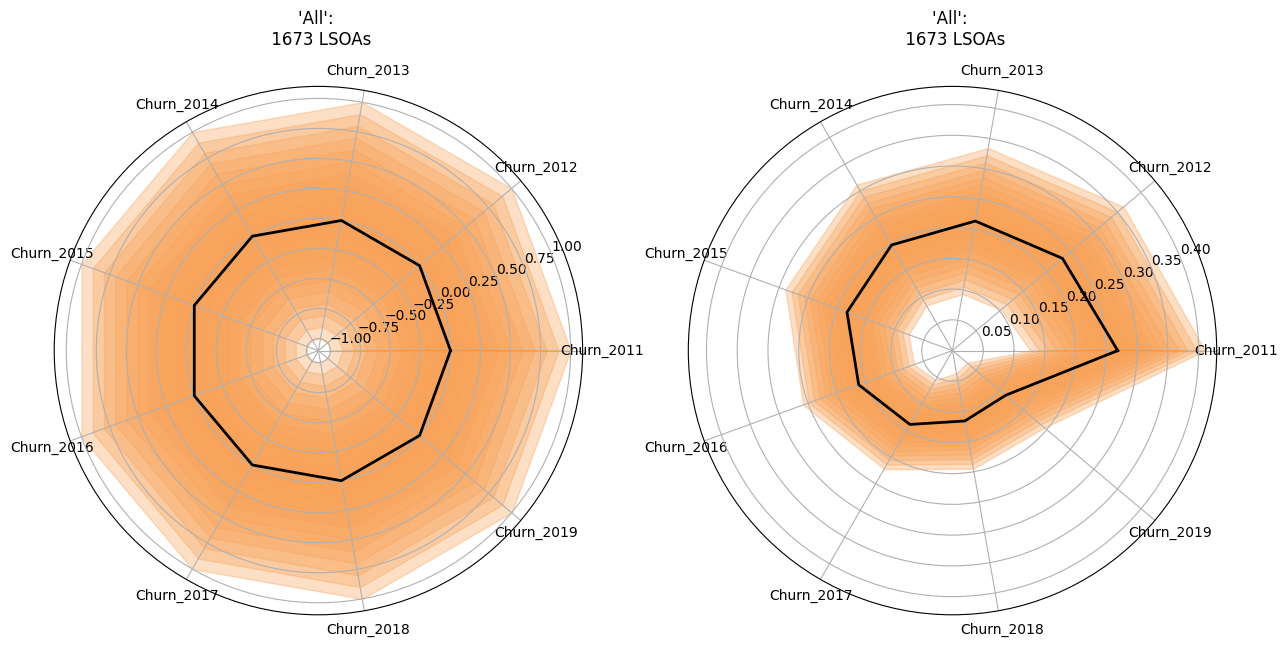

In [336]:
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=2, nrows=1, figsize=(15,10), sharex=True, sharey=False)

gentr_class = 3
key = 'All'
class_data = indicators_manchester_standard[indicators_manchester_standard['gentrification_prediction_code'] == gentr_class]
plot_mean_rose_with_group_labels(axs[0], indicators_manchester_standard, plot_colors[gentr_class],numeric_cols)
axs[0].set_title(f"'{key}': \n {len(indicators_manchester_standard)} LSOAs", size=12, pad=30)

class_data = indicators_manchester_minmax[indicators_manchester_minmax['gentrification_prediction_code'] == gentr_class]
plot_mean_rose_with_group_labels(axs[1], indicators_manchester_minmax, plot_colors[gentr_class],numeric_cols)
axs[1].set_title(f"'{key}': \n {len(indicators_manchester_minmax)} LSOAs", size=12, pad=30)

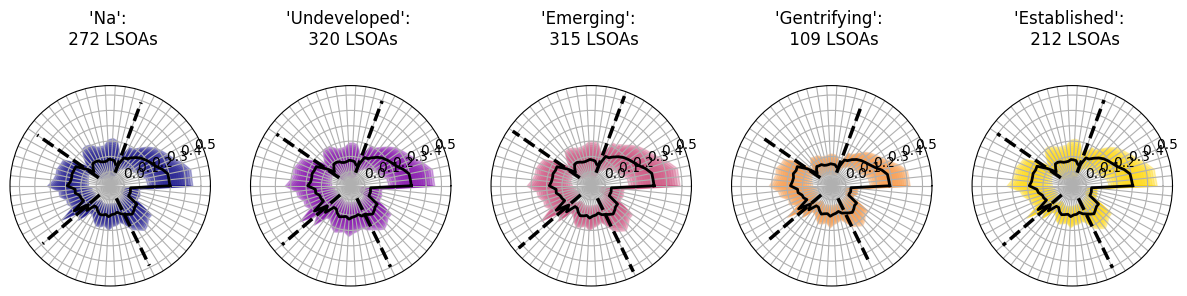

In [302]:
# pattern = '|'.join(['Manchester', 'Stockport', 'Salford', 'Trafford', 'Tameside'])
# indicators_manchester_filtered = indicators_manchester[indicators_manchester['LA_NAME'].str.contains(pattern)] 

fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(15,10), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_manchester_minmax[indicators_manchester_minmax['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:
        plot_mean_rose_with_group_labels(ax, class_data, plot_colors[gentr_class],numeric_cols)
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        ax.set_title(f"'{key}': \n {len(class_data)} LSOAs", size=12, pad=30)

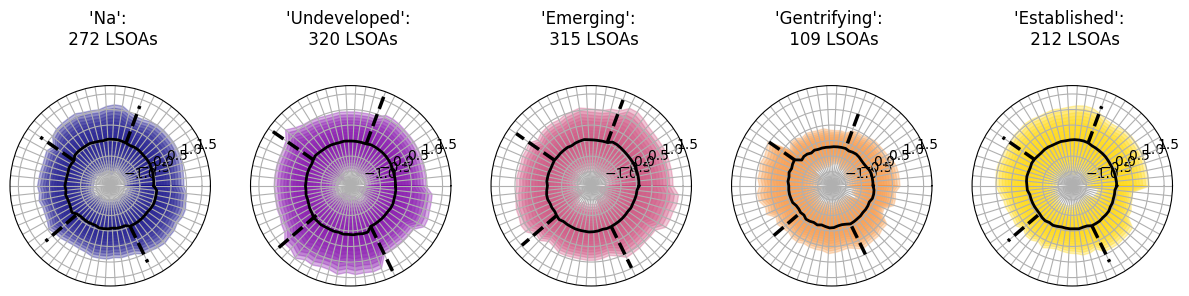

In [303]:
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(15,10), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_manchester_standard[indicators_manchester_standard['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:
        plot_mean_rose_with_group_labels(ax, class_data, plot_colors[gentr_class],numeric_cols)
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        ax.set_title(f"'{key}': \n {len(class_data)} LSOAs", size=12, pad=30)

## Plot just the mean value for each

In [169]:
indicators_manchester_short = indicators_manchester.copy()

# Dictionary of variable prefixes and their year ranges
variables = {'PROF2POP': range(2010, 2021),'Churn': range(2008, 2020), 'NINO': range(2008, 2021), 'JSA': range(2008, 2021),'HP': range(2008, 2021)}

# Loop over each variable type to compute mean
for var, years in variables.items():
    cols = [f"{var}_{year}_Z" for year in years]
    indicators_manchester_short[f'{var}_mean'] = indicators_manchester_short[cols].mean(axis=1)

# Drop all original year columns
all_cols = [f"{var}_{year}" for var, years in variables.items() for year in years]
indicators_manchester_short.drop(columns=all_cols, inplace=True)

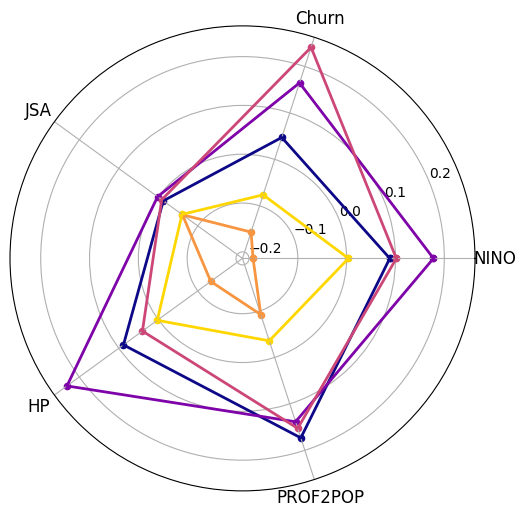

In [180]:
variables = ['NINO_mean', 'Churn_mean', 'JSA_mean', 'HP_mean', 'PROF2POP_mean']

# Example usage for creating plots
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(6,8), sharex=True, sharey=True)

pattern = '|'.join(['Manchester', 'Stockport', 'Salford', 'Trafford', 'Tameside'])
indicators_manchester_short_filtered = indicators_manchester_short[indicators_manchester_short['LA_NAME'].str.contains(pattern)] 

for gentr_class, val in enumerate(np.unique(indicators_manchester_short_filtered['gentrification_prediction_code'])):
    class_data = indicators_manchester_short_filtered[indicators_manchester_short_filtered['gentrification_prediction_code'] == gentr_class]
    if len(class_data)>0:
        plot_mean_rose_plot(ax, class_data, plot_colors[gentr_class], just_means=True)

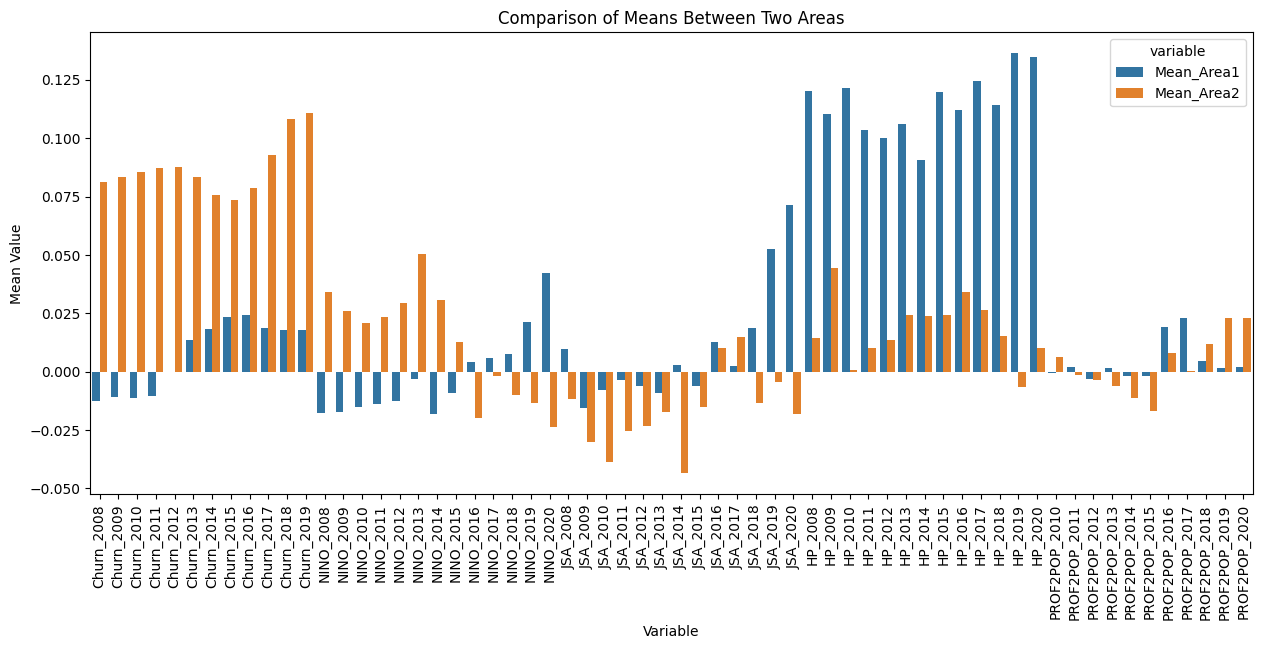

In [407]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
sns.barplot(data=comparison_df.melt(id_vars="Variable", value_vars=["Mean_Area1", "Mean_Area2"]),
            x="Variable", y="value", hue="variable")
plt.xticks(rotation=90)
plt.title("Comparison of Means Between Two Areas")
plt.ylabel("Mean Value")
plt.xlabel("Variable")
plt.show()
